In [2]:
# Import required libraries and set display configurations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for high-resolution plots in Jupyter
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['axes.unicode_minus'] = False

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cpu
CUDA available: False


In [3]:
# Generate synthetic image-like dataset (simulating grayscale images)
# Create 28x28 "images" with 2 classes
n_samples = 2000
img_size = 28
n_features = img_size * img_size

# Generate classification data and reshape to image format
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=100,
    n_redundant=50,
    n_classes=2,
    random_state=42
)

# Reshape to image format (samples, channels, height, width) for PyTorch
X = X.reshape(-1, 1, img_size, img_size)

# Normalize pixel values to [0, 1]
X = X.astype('float32') / 255.0

# Convert to PyTorch tensors
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y, dtype=torch.long)

# Display basic information about the dataset
print("Dataset shape:", X_tensor.shape)
print("Target shape:", y_tensor.shape)
print("Number of classes:", len(torch.unique(y_tensor)))
print("Class distribution:", torch.bincount(y_tensor))
print("Image dimensions:", X_tensor[0].shape)
print("\nFirst few target values:", y_tensor[:10])

Dataset shape: torch.Size([2000, 1, 28, 28])
Target shape: torch.Size([2000])
Number of classes: 2
Class distribution: tensor([ 998, 1002])
Image dimensions: torch.Size([1, 28, 28])

First few target values: tensor([0, 1, 1, 0, 0, 1, 1, 1, 0, 1])


In [4]:
# Data preprocessing pipeline
def preprocess_data(X_tensor, y_tensor):
    """
    Preprocess the dataset: normalize and split
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor
    )

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(X_tensor, y_tensor)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training target distribution:", torch.bincount(y_train))
print("Test target distribution:", torch.bincount(y_test))

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training set shape: torch.Size([1600, 1, 28, 28])
Test set shape: torch.Size([400, 1, 28, 28])
Training target distribution: tensor([798, 802])
Test target distribution: tensor([200, 200])


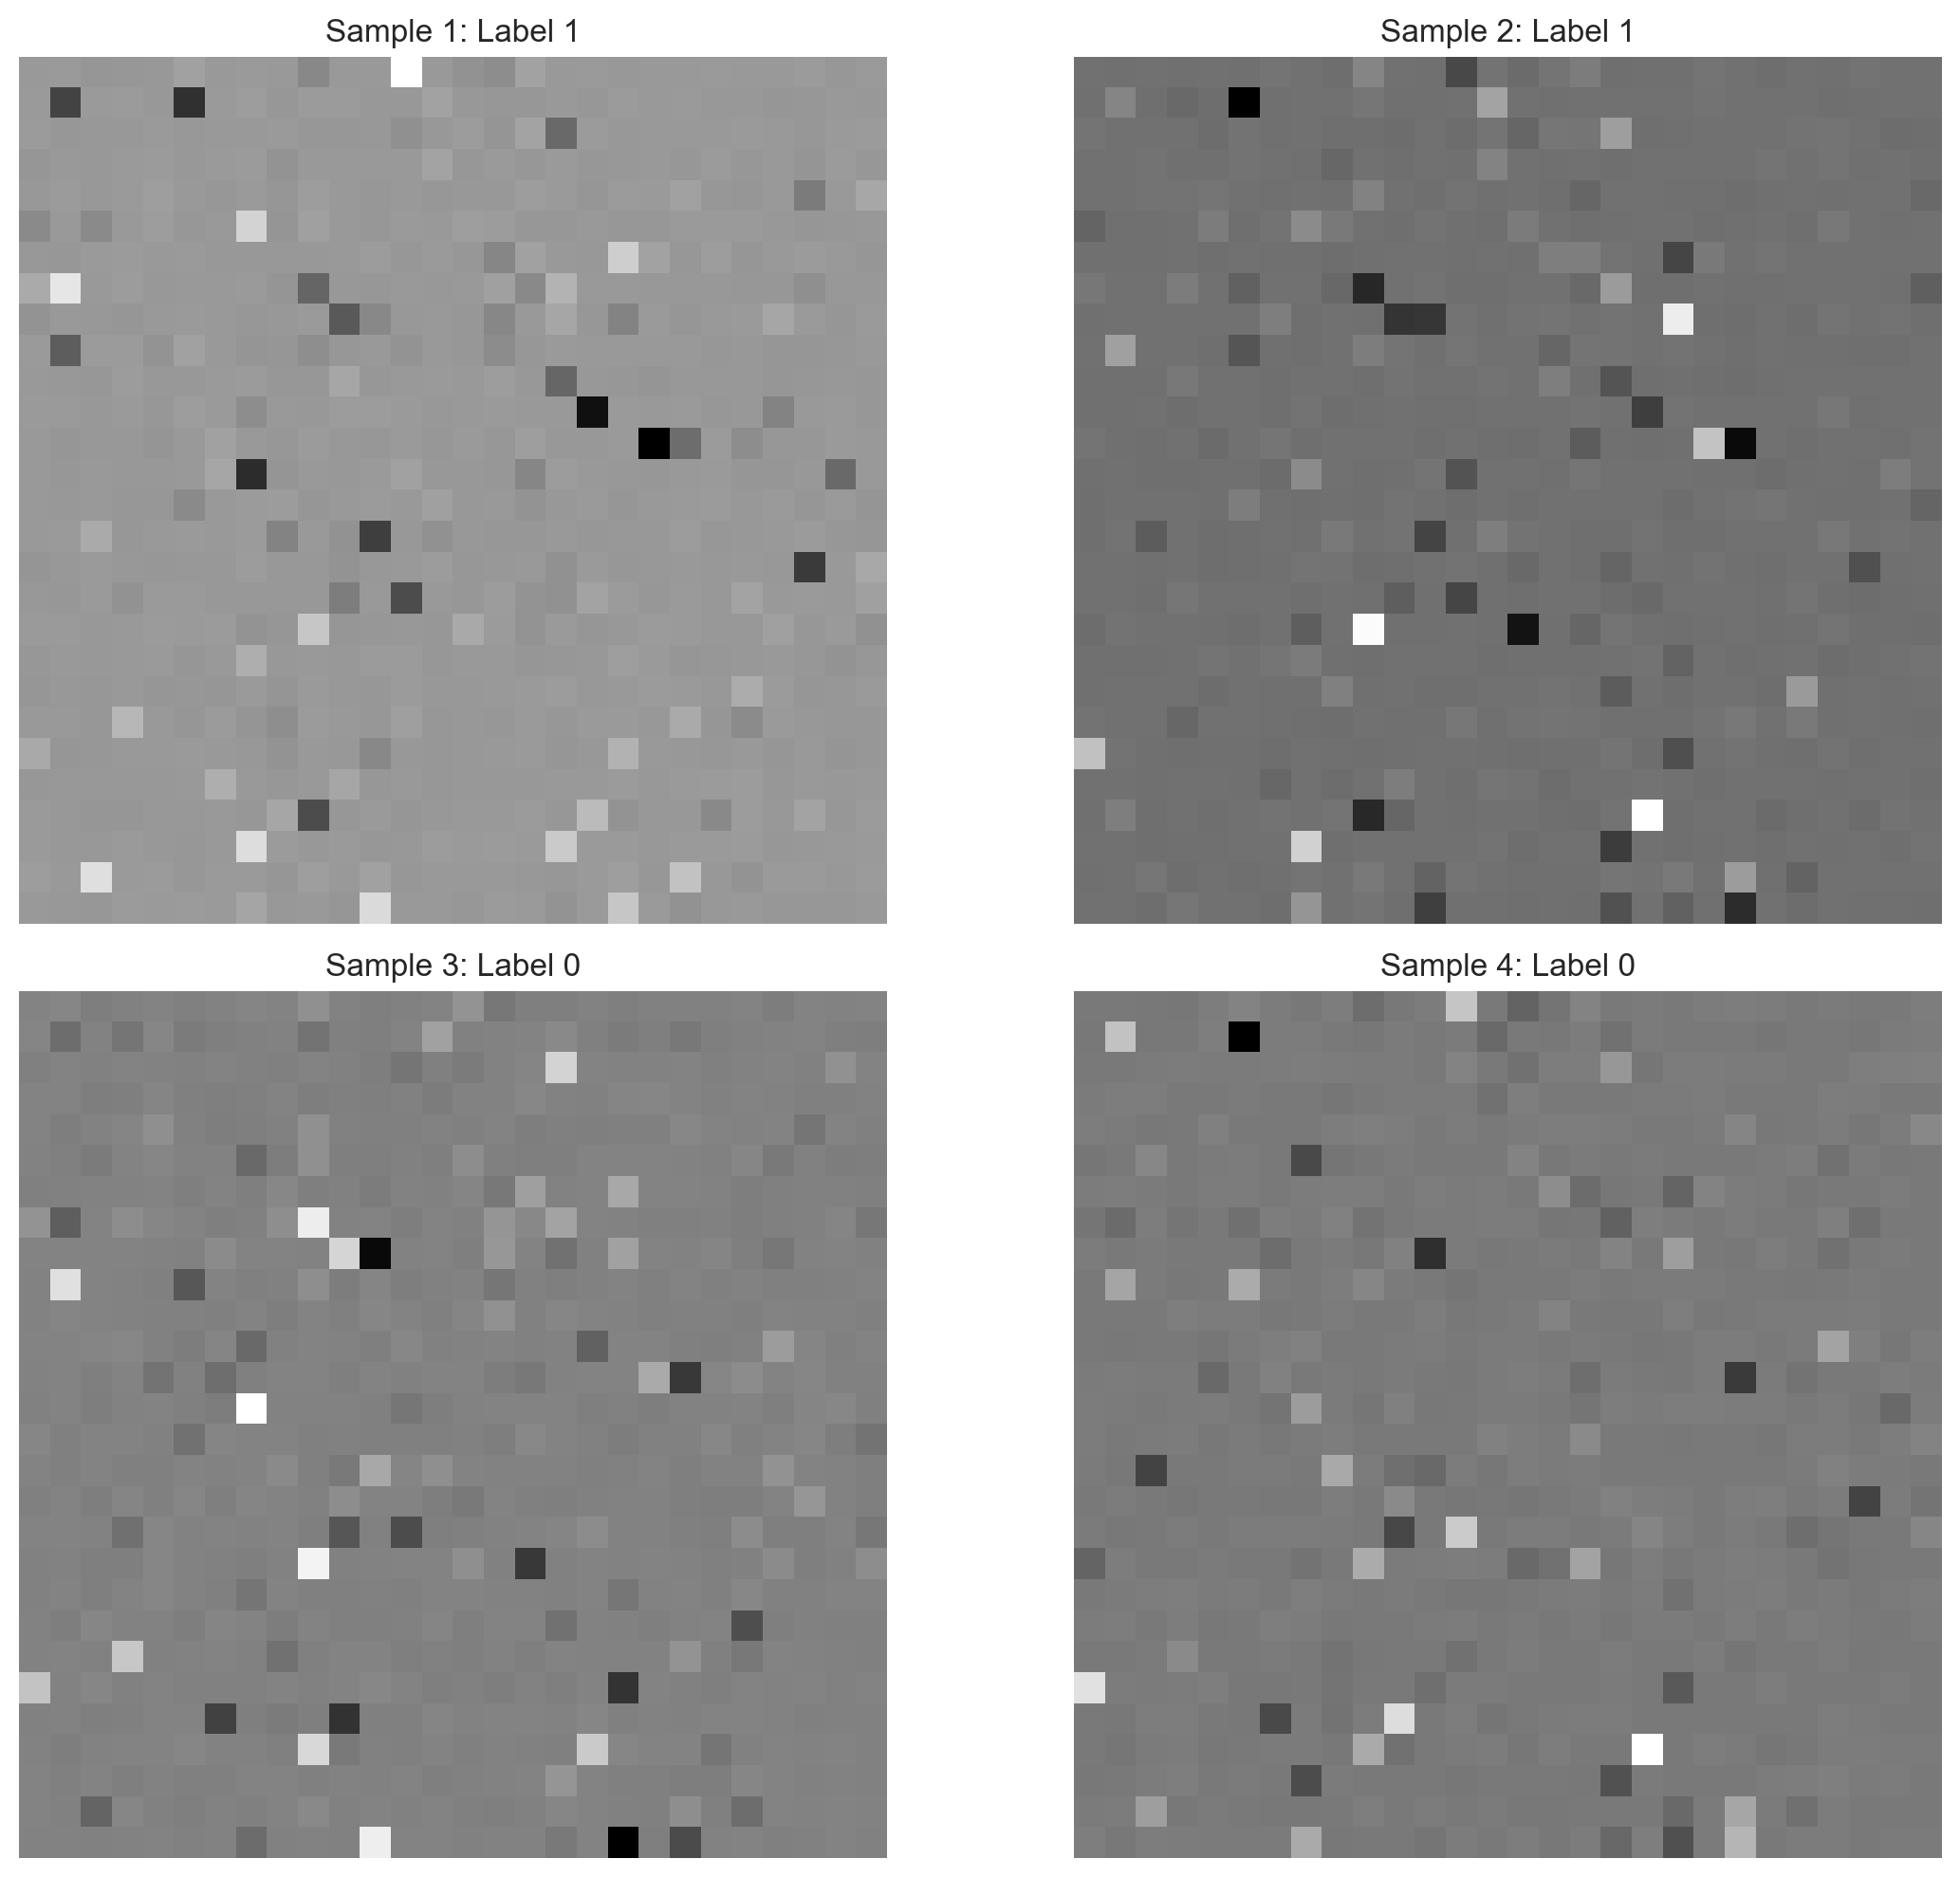

<Figure size 1200x1000 with 0 Axes>

In [5]:
# Exploratory Data Analysis
fig, axes = plt.subplots(2, 2)

# Display sample images
for i in range(4):
    row, col = divmod(i, 2)
    axes[row, col].imshow(X_train[i].squeeze(), cmap='gray')
    axes[row, col].set_title(f'Sample {i+1}: Label {y_train[i].item()}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Distribution of target variable
unique, counts = torch.unique(y_tensor, return_counts=True)
axes[0,0].bar(unique.numpy(), counts.numpy())
axes[0,0].set_title('Distribution of Target Variable')
axes[0,0].set_xlabel('Class')
axes[0,0].set_ylabel('Count')

# Pixel value distribution (first sample)
axes[0,1].hist(X_train[0].flatten().numpy(), bins=50, edgecolor='black', alpha=0.7)
axes[0,1].set_title('Pixel Value Distribution (Sample Image)')
axes[0,1].set_xlabel('Pixel Value')
axes[0,1].set_ylabel('Frequency')

# Average image per class
for i, class_label in enumerate(torch.unique(y_train)):
    class_indices = (y_train == class_label).nonzero(as_tuple=True)[0]
    class_images = X_train[class_indices]
    avg_image = torch.mean(class_images, dim=0)
    axes[1,0].imshow(avg_image.squeeze(), cmap='gray', alpha=0.7)
    axes[1,0].set_title(f'Average Image for Class {class_label.item()}')
    axes[1,0].axis('off')

# Pixel intensity distribution across all images
all_pixel_values = X_train.flatten().numpy()
axes[1,1].hist(all_pixel_values, bins=50, edgecolor='black', alpha=0.7)
axes[1,1].set_title('Overall Pixel Intensity Distribution')
axes[1,1].set_xlabel('Pixel Value')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [6]:
# Define CNN model
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNClassifier, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 64)  # Adjusted based on image size after convolutions
        self.fc2 = nn.Linear(64, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolutional layers with pooling
        x = self.pool(self.relu(self.conv1(x)))  # (batch, 32, 14, 14)
        x = self.pool(self.relu(self.conv2(x)))  # (batch, 64, 7, 7)
        x = self.pool(self.relu(self.conv3(x)))  # (batch, 64, 3, 3)

        # Flatten
        x = x.view(-1, 64 * 3 * 3)  # Flatten for fully connected layer

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Initialize the model
model = CNNClassifier(num_classes=2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Display model architecture
print("Model Architecture:")
print(model)
print(f"\nTotal number of parameters: {sum(p.numel() for p in model.parameters())}")

Model Architecture:
CNNClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

Total number of parameters: 92802


In [7]:
# Train the model
num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train

    # Validation phase (using a simple validation split from training data)
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in train_loader:  # Using train_loader for validation (in practice, use a separate val_loader)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(train_loader)
    epoch_val_acc = 100 * correct_val / total_val

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

Epoch [1/20], Train Loss: 0.6943, Train Acc: 50.19%, Val Loss: 0.6931, Val Acc: 50.12%
Epoch [2/20], Train Loss: 0.6935, Train Acc: 50.19%, Val Loss: 0.6931, Val Acc: 50.12%
Epoch [3/20], Train Loss: 0.6931, Train Acc: 50.12%, Val Loss: 0.6931, Val Acc: 49.88%
Epoch [4/20], Train Loss: 0.6937, Train Acc: 49.94%, Val Loss: 0.6931, Val Acc: 50.12%
Epoch [5/20], Train Loss: 0.6928, Train Acc: 51.25%, Val Loss: 0.6931, Val Acc: 50.12%
Epoch [6/20], Train Loss: 0.6934, Train Acc: 48.69%, Val Loss: 0.6931, Val Acc: 50.12%
Epoch [7/20], Train Loss: 0.6930, Train Acc: 50.50%, Val Loss: 0.6930, Val Acc: 50.19%
Epoch [8/20], Train Loss: 0.6933, Train Acc: 49.06%, Val Loss: 0.6929, Val Acc: 51.12%
Epoch [9/20], Train Loss: 0.6928, Train Acc: 52.31%, Val Loss: 0.6913, Val Acc: 63.75%
Epoch [10/20], Train Loss: 0.6884, Train Acc: 56.44%, Val Loss: 0.6796, Val Acc: 63.25%
Epoch [11/20], Train Loss: 0.6671, Train Acc: 60.88%, Val Loss: 0.6517, Val Acc: 65.06%
Epoch [12/20], Train Loss: 0.6523, Train 

Model Performance Metrics:
Test Accuracy: 74.00%
AUC Score: 0.8195

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       200
           1       0.71      0.80      0.75       200

    accuracy                           0.74       400
   macro avg       0.74      0.74      0.74       400
weighted avg       0.74      0.74      0.74       400



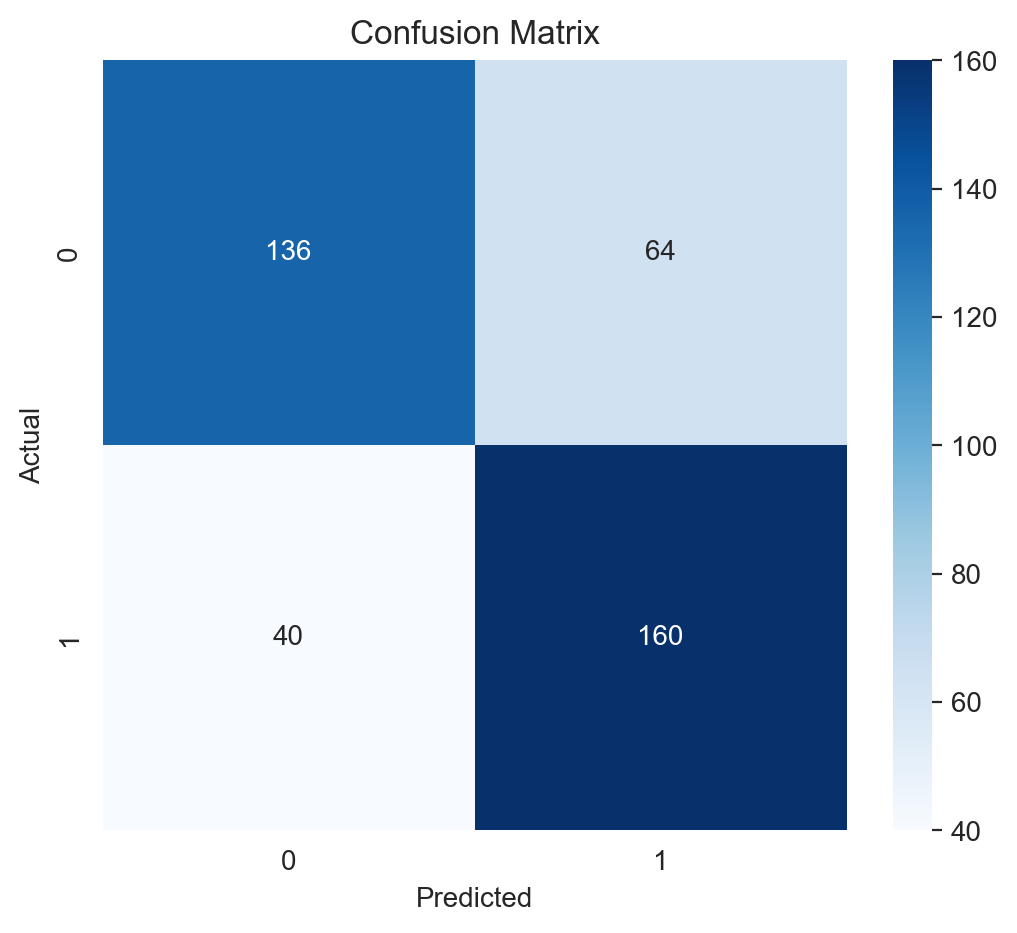

In [8]:
# Evaluate the model on test set
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probabilities[:, 1].numpy())  # Probability of positive class for binary classification

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate evaluation metrics
test_accuracy = 100 * np.sum(all_preds == all_labels) / len(all_labels)
auc_score = roc_auc_score(all_labels, all_probs)

print("Model Performance Metrics:")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"AUC Score: {auc_score:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

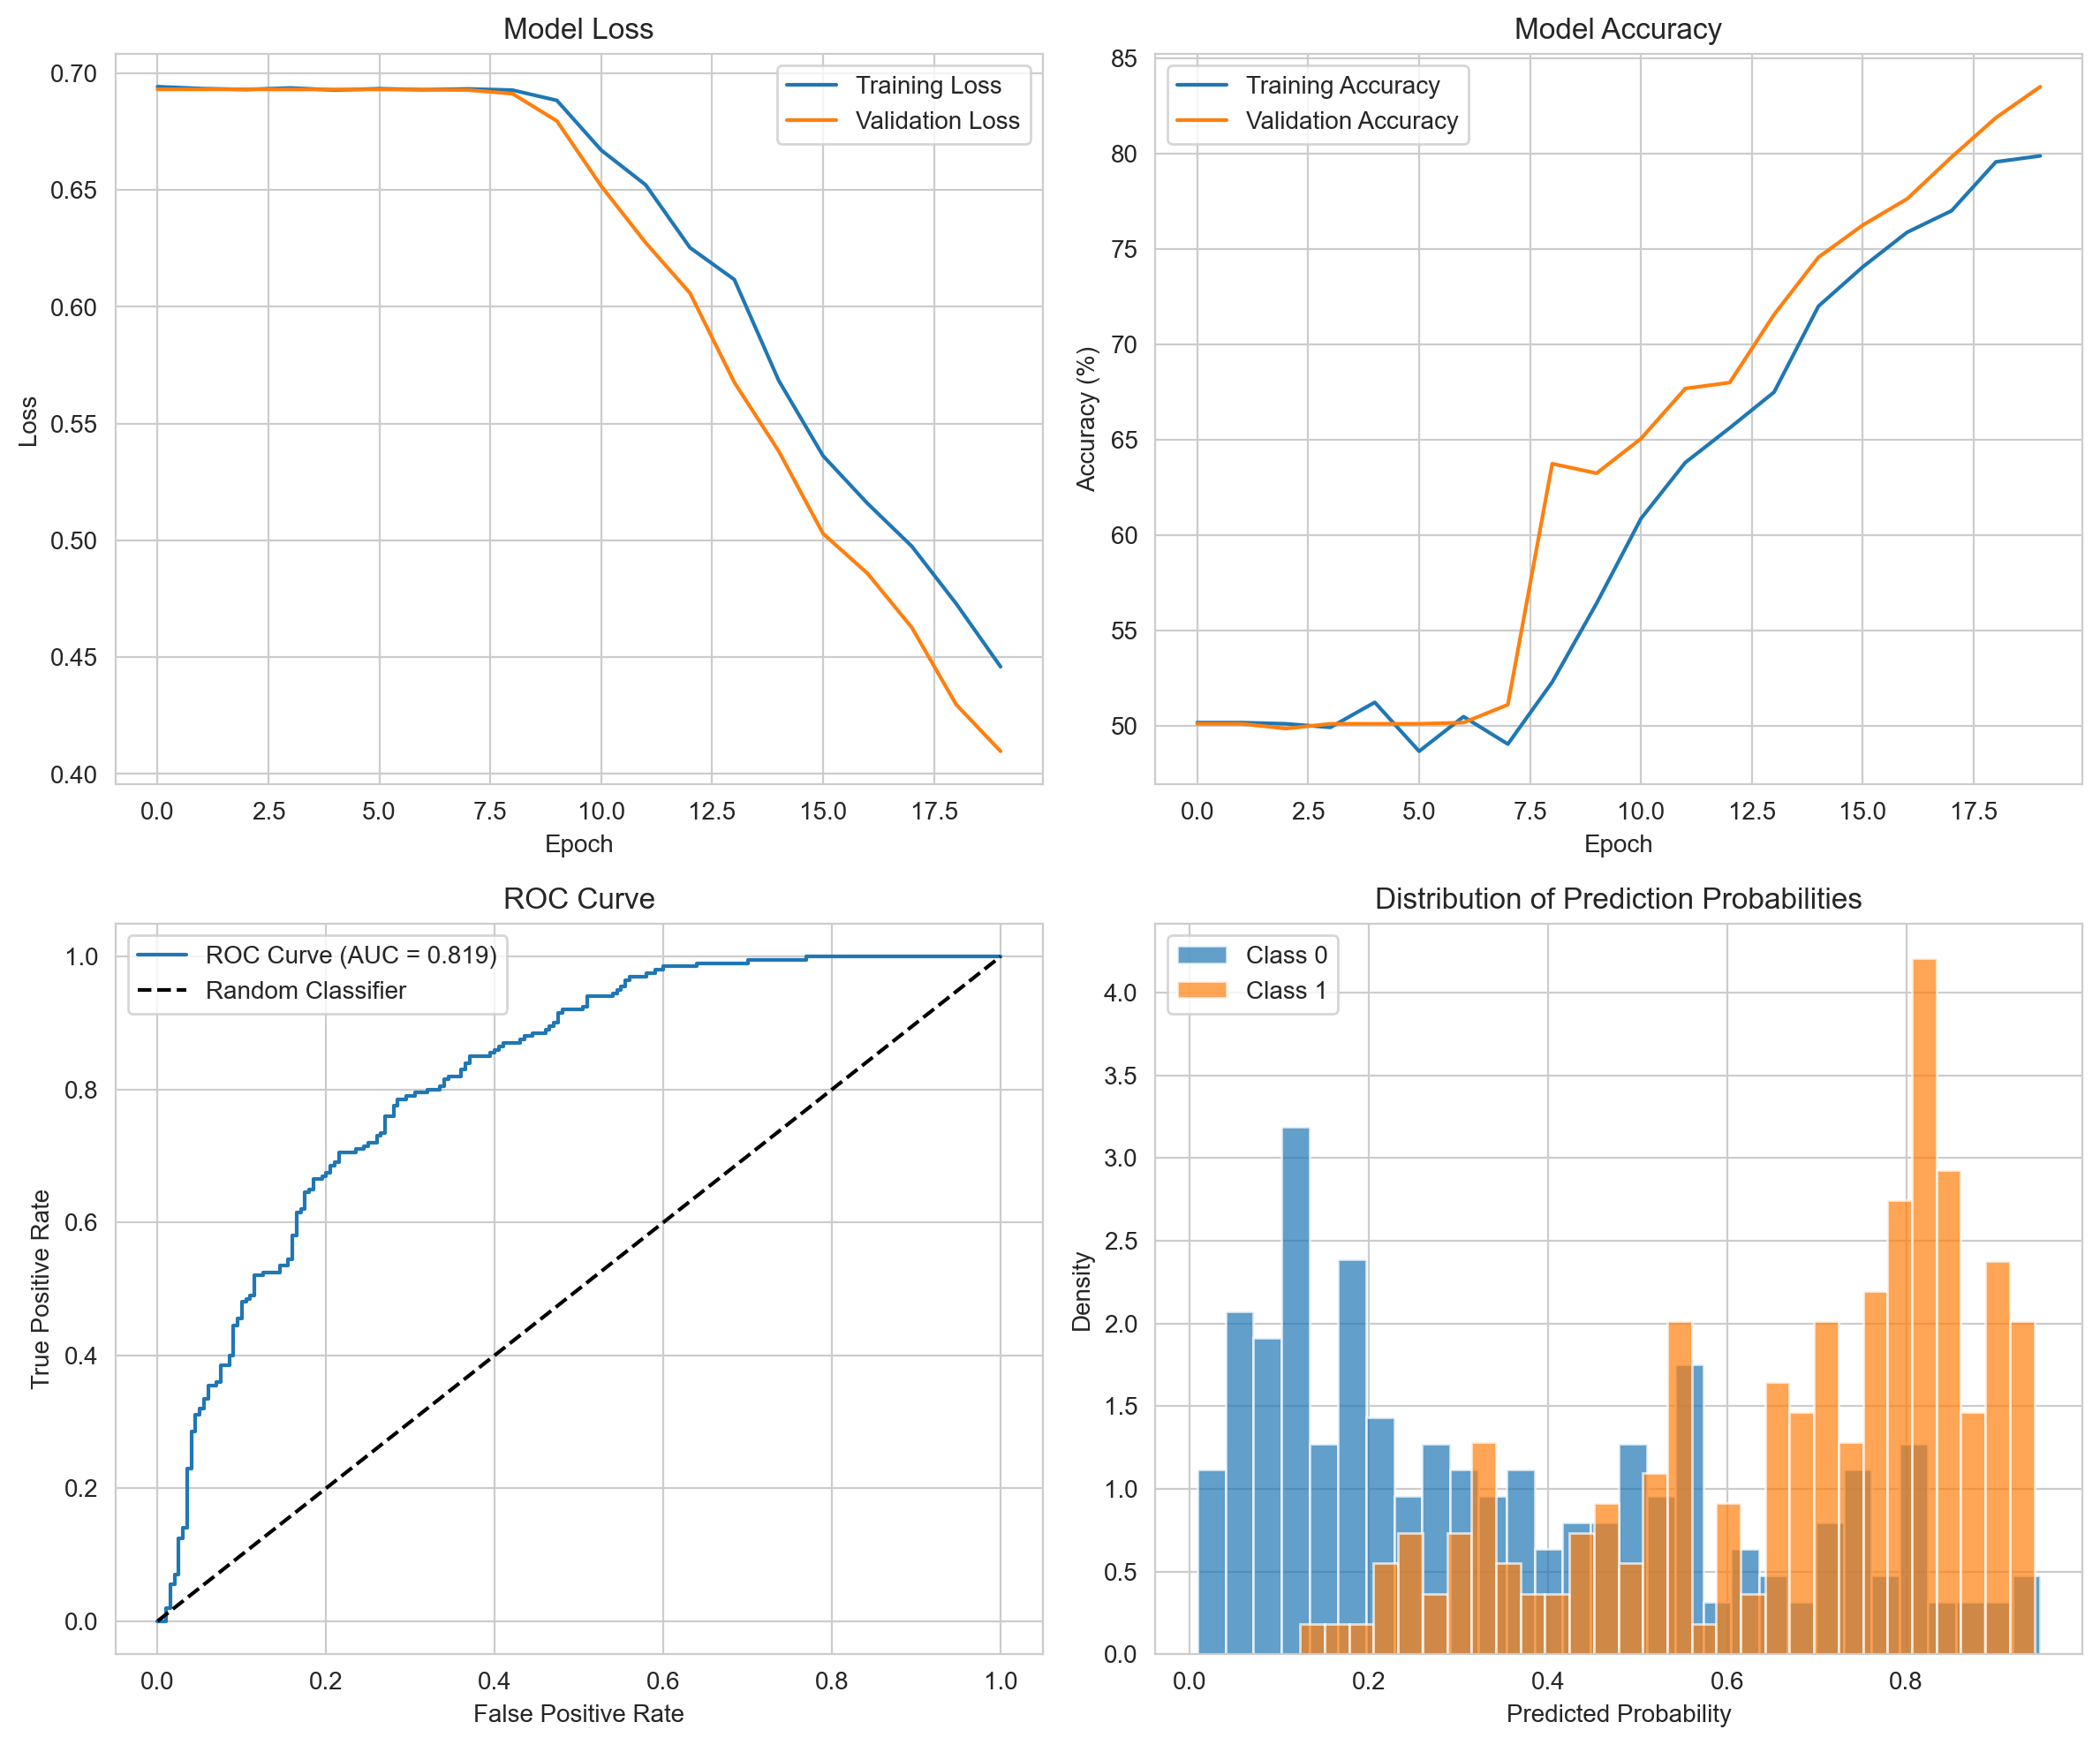

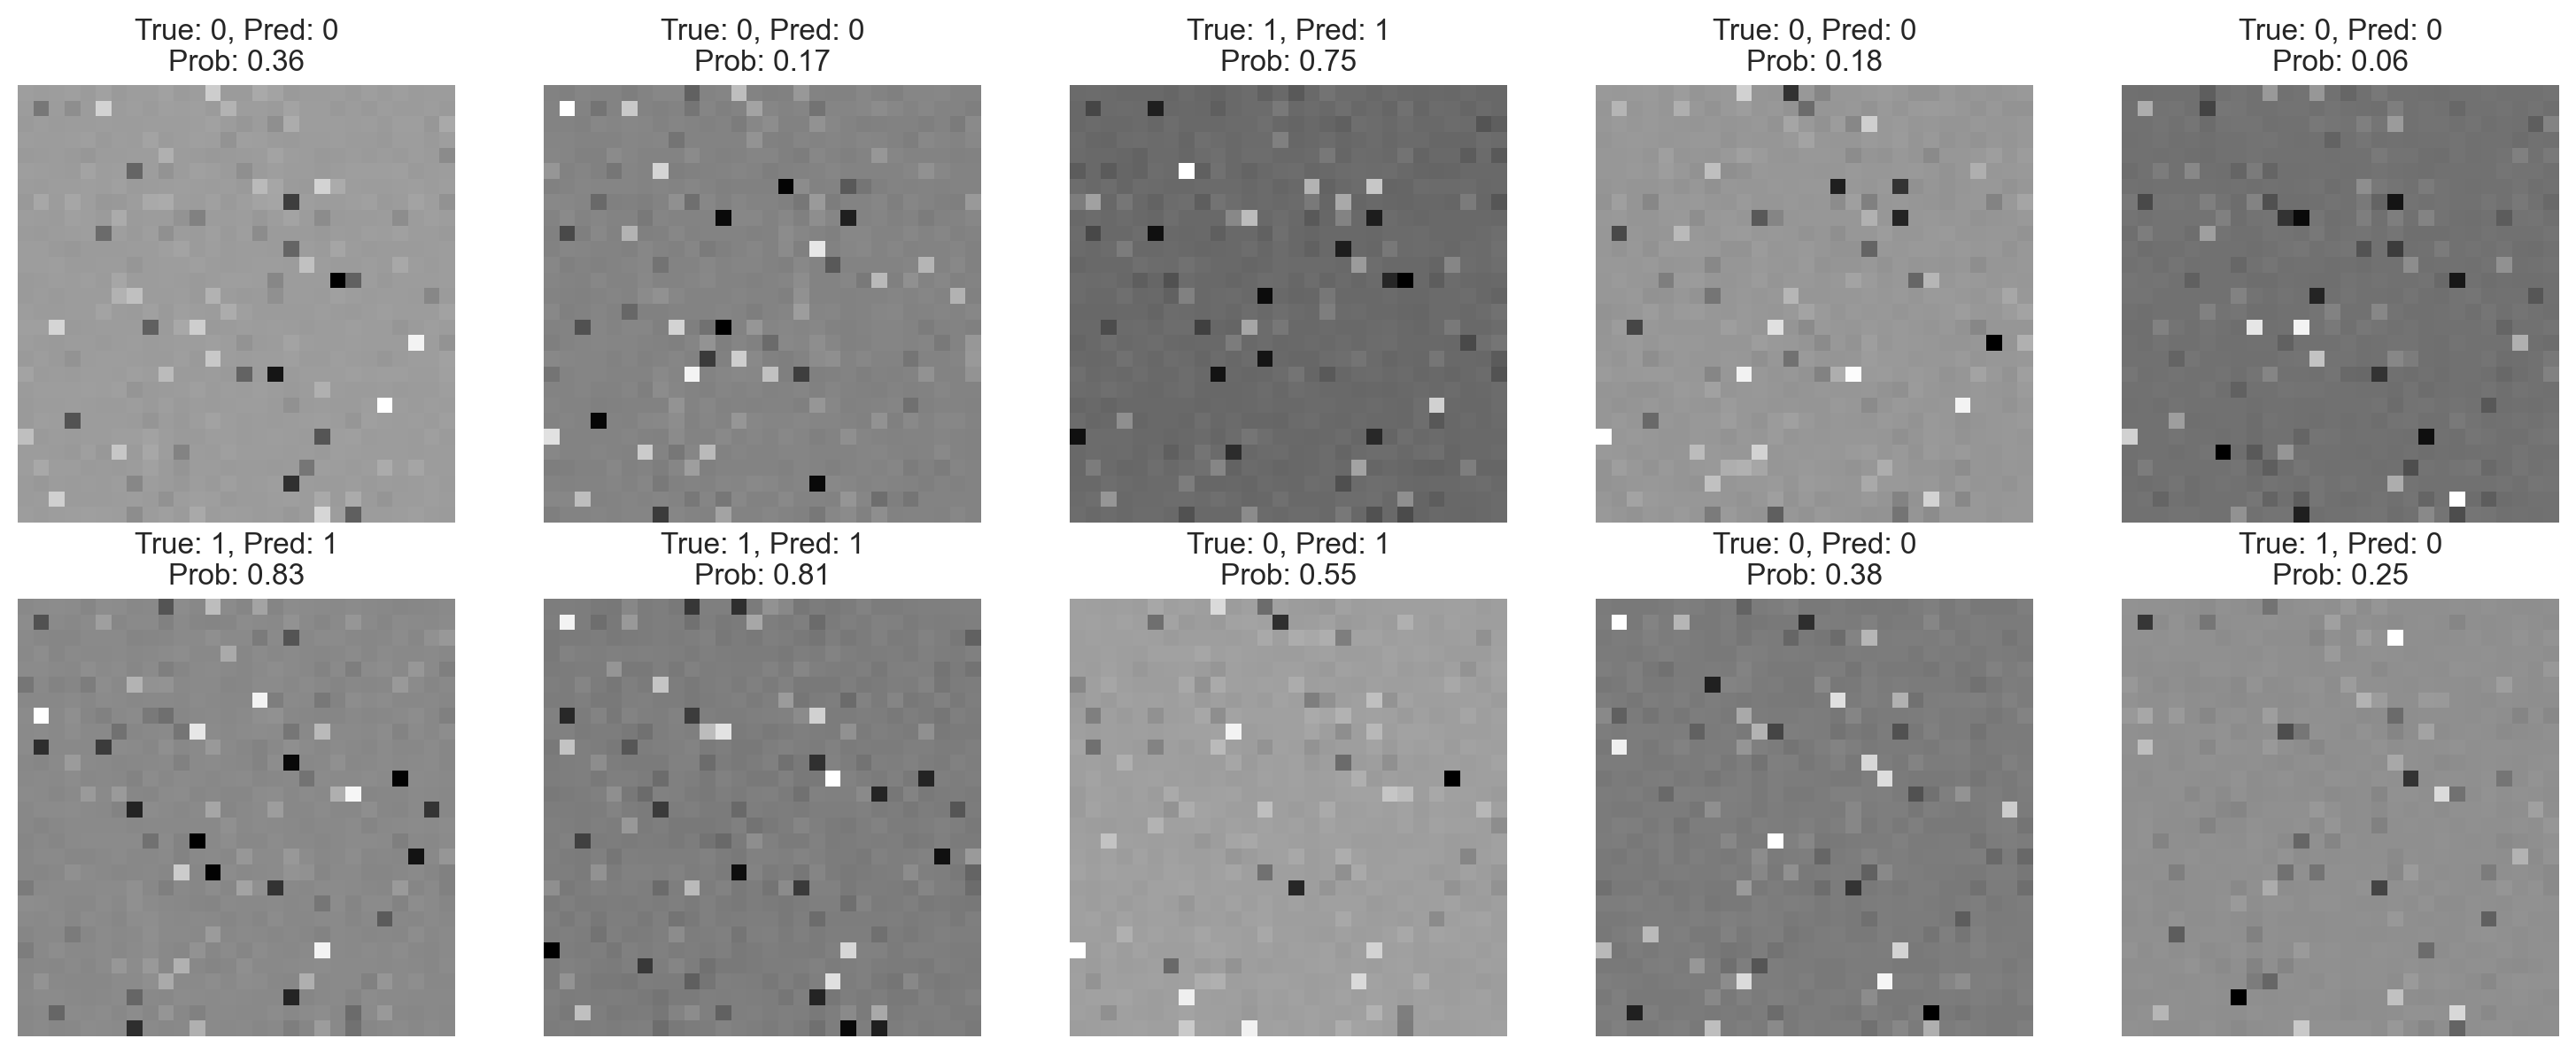

In [9]:
# Visualization of results
fig, axes = plt.subplots(2, 2)

# Training history - loss
axes[0,0].plot(train_losses, label='Training Loss')
axes[0,0].plot(val_losses, label='Validation Loss')
axes[0,0].set_title('Model Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()

# Training history - accuracy
axes[0,1].plot(train_accuracies, label='Training Accuracy')
axes[0,1].plot(val_accuracies, label='Validation Accuracy')
axes[0,1].set_title('Model Accuracy')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy (%)')
axes[0,1].legend()

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
axes[1,0].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
axes[1,0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curve')
axes[1,0].legend()

# Prediction probability distribution
axes[1,1].hist(all_probs[all_labels==0], bins=30, alpha=0.7, label='Class 0', density=True)
axes[1,1].hist(all_probs[all_labels==1], bins=30, alpha=0.7, label='Class 1', density=True)
axes[1,1].set_xlabel('Predicted Probability')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Distribution of Prediction Probabilities')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Show some test predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
test_iter = iter(test_loader)
inputs, labels = next(test_iter)

with torch.no_grad():
    outputs = model(inputs[:10])
    probabilities = F.softmax(outputs, dim=1)
    _, predicted = torch.max(outputs[:10], 1)

for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(inputs[i].squeeze(), cmap='gray')
    ax.set_title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}\nProb: {probabilities[i][1]:.2f}')
    ax.axis('off')

plt.tight_layout()
plt.show()